<a href="https://colab.research.google.com/github/kim-bo-saeng/dacon_jeju/blob/master/jeju_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor , ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# 한글폰트사용하기

import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 144465 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


### Check Version

In [4]:
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))
print('Scikit-Learn : %s'%(sk.__version__))
!python --version

Pandas : 1.0.5
Numpy : 1.18.5
Scikit-Learn : 0.22.2.post1
Python 3.6.9


### 데이터 전처리

In [5]:
row_data = pd.read_csv('/gdrive/My Drive/data_analysis/jeju/201901-202003.csv')
print(row_data.shape)
row_data.tail()

(24697792, 12)


,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
24697787,202003,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,3,43300,4
24697788,202003,충북,충주시,휴양콘도 운영업,충북,충주시,40s,1,3,3,35000,3
24697789,202003,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,4,188000,6
24697790,202003,충북,충주시,휴양콘도 운영업,충북,충주시,50s,2,4,4,99000,6
24697791,202003,충북,충주시,휴양콘도 운영업,충북,충주시,60s,1,5,3,194000,3


In [6]:
# 빈값찾기
row_data.isnull().sum()

REG_YYMM             0
CARD_SIDO_NM         0
CARD_CCG_NM      87213
STD_CLSS_NM          0
HOM_SIDO_NM          0
HOM_CCG_NM      147787
AGE                  0
SEX_CTGO_CD          0
FLC                  0
CSTMR_CNT            0
AMT                  0
CNT                  0
dtype: int64

In [7]:
# CARD_CCG_NM / HOM_CCG_NM 모두 세종시일경우 CARD_CCG_NM / HOM_CCG_NM 의 값이 빈값이므로 세종으로 채워줌
print(row_data[row_data['CARD_CCG_NM'].isna()]['CARD_SIDO_NM'].value_counts())
print(row_data[row_data['HOM_CCG_NM'].isna()]['HOM_SIDO_NM'].value_counts())

row_data = row_data.fillna('세종')
row_data.isnull().sum()

세종    87213
Name: CARD_SIDO_NM, dtype: int64
세종    147787
Name: HOM_SIDO_NM, dtype: int64


REG_YYMM        0
CARD_SIDO_NM    0
CARD_CCG_NM     0
STD_CLSS_NM     0
HOM_SIDO_NM     0
HOM_CCG_NM      0
AGE             0
SEX_CTGO_CD     0
FLC             0
CSTMR_CNT       0
AMT             0
CNT             0
dtype: int64

### EDA

In [8]:
row_data.tail()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
24697787,202003,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,3,43300,4
24697788,202003,충북,충주시,휴양콘도 운영업,충북,충주시,40s,1,3,3,35000,3
24697789,202003,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,4,188000,6
24697790,202003,충북,충주시,휴양콘도 운영업,충북,충주시,50s,2,4,4,99000,6
24697791,202003,충북,충주시,휴양콘도 운영업,충북,충주시,60s,1,5,3,194000,3


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


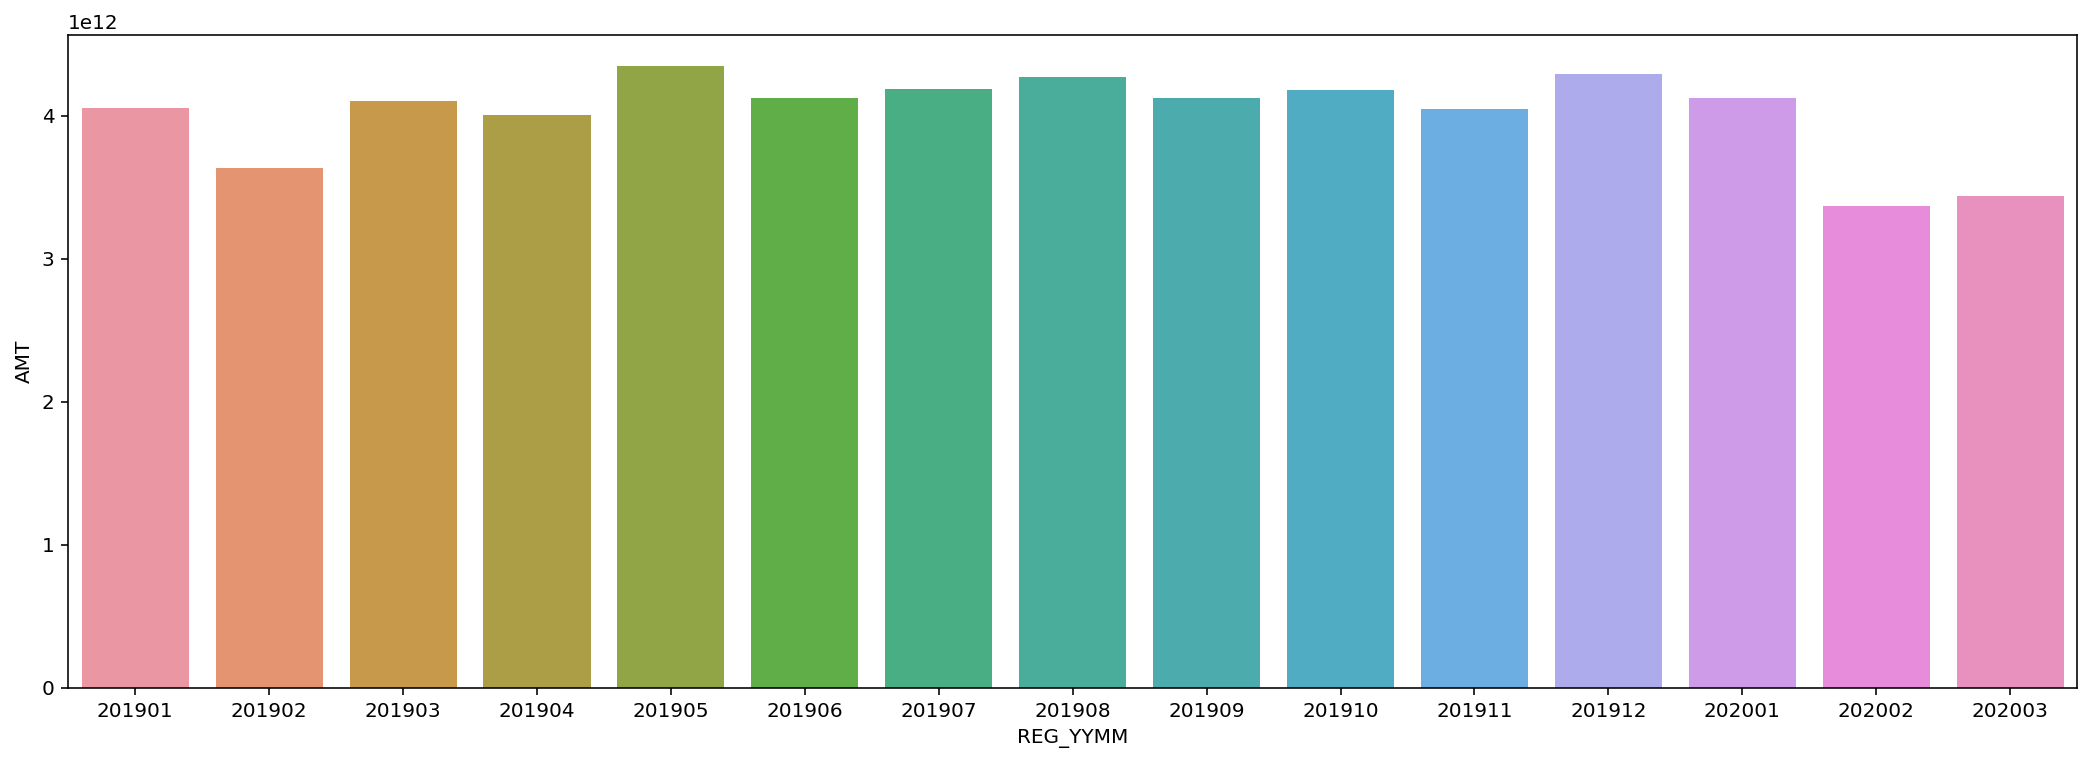

In [9]:
YYMM_AMT_data = pd.DataFrame(row_data.groupby(['REG_YYMM'])['AMT'].sum()).reset_index()
plt.figure(figsize=(18,6))
sns.barplot(data = YYMM_AMT_data, x = 'REG_YYMM', y = 'AMT')

### 4월을 예측하기 위해 코로나의 영향을 모델에게 학습시켜야 하므로 2019년 1월과 2020년 1월은 코로나의 영향이 없다고 보여지기때문에 제외하고 2019년 5월부터 12월까지도 모델이 학습함에 있어 오해를 줄수 있으므로 제외한다 즉, 2019년 2월/3월/4월 과 2020년 2월,3월을 이용한다

### Feature Enginnering

In [10]:
# 모델 학습을 위한 데이터 선택 : 2019년 2월/3월/4월 + 2020년 2월/3월 
data190234_2023 = row_data[(row_data['REG_YYMM'] == 201902) | (row_data['REG_YYMM'] == 201903) | (row_data['REG_YYMM'] == 201904) |
                             (row_data['REG_YYMM'] == 202002) | (row_data['REG_YYMM'] == 202003)
                            ]
data190234_2023.tail()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
24697787,202003,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,3,43300,4
24697788,202003,충북,충주시,휴양콘도 운영업,충북,충주시,40s,1,3,3,35000,3
24697789,202003,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,4,188000,6
24697790,202003,충북,충주시,휴양콘도 운영업,충북,충주시,50s,2,4,4,99000,6
24697791,202003,충북,충주시,휴양콘도 운영업,충북,충주시,60s,1,5,3,194000,3


In [ ]:
# 모델 학습을 위한 데이터 선택 : 2019년 1월/2월/7월 + 2020년 1월/2월 만 뽑은 데이터
#data190127_2012 = row_data[(row_data['REG_YYMM'] == 201901) | (row_data['REG_YYMM'] == 201902) | (row_data['REG_YYMM'] == 201907) |
#                            (row_data['REG_YYMM'] == 202001) | (row_data['REG_YYMM'] == 202002)
#                           ]
#data190127_2012

In [ ]:
# 소비자동향지수 데이터
#customer_index = pd.read_excel('/gdrive/My Drive/data_analysis/jeju/customer_index.xls', index_col=0)
#customer_index = customer_index.T.reset_index().rename(columns = {'index' : 'REG_YYMM'})

#row_data = row_data.merge(customer_index, how = 'left', on = ['REG_YYMM'])
#row_data['Consumer_sentiment_index'] = row_data['Consumer_sentiment_index'].astype(int)
#row_data.tail()

In [11]:
def grap_year(data):
  data = str(data)
  return int(data[:4])

def grap_month(data):
  data = str(data)
  return int(data[4:])

In [12]:
# 날짜 처리
temp_data = data190234_2023.copy()
temp_data = temp_data.fillna('')
temp_data['year'] = temp_data['REG_YYMM'].apply(lambda x : grap_year(x))
temp_data['month'] = temp_data['REG_YYMM'].apply(lambda x : grap_month(x))
temp_data = temp_data.drop(['REG_YYMM'], axis = 1)
print(temp_data.shape)
temp_data.tail()

(7518084, 13)


,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
24697787,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,3,43300,4,2020,3
24697788,충북,충주시,휴양콘도 운영업,충북,충주시,40s,1,3,3,35000,3,2020,3
24697789,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,4,188000,6,2020,3
24697790,충북,충주시,휴양콘도 운영업,충북,충주시,50s,2,4,4,99000,6,2020,3
24697791,충북,충주시,휴양콘도 운영업,충북,충주시,60s,1,5,3,194000,3,2020,3


In [19]:
# 데이터 정제
df = temp_data.copy()

# CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM 컬럼은 고정으로 사용하고 CARD_CCG_NM, HOM_CCG_NM, CSTMR_CNT, CNT컬럼은 고정으로 제거한뒤 나머지 컬럼을 조합해보며 df 생성

# 기본
df = df.drop(['CARD_CCG_NM', 'HOM_CCG_NM','CSTMR_CNT', 'CNT'], axis = 1)
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM',	'SEX_CTGO_CD', 'AGE',	'FLC', 'year',	'month']

# CARD_CCG_NM, HOM_CCG_NM , SEX_CTGO_CD, AGE 제거
#df = df.drop(['CARD_CCG_NM', 'HOM_CCG_NM','SEX_CTGO_CD','AGE','CSTMR_CNT', 'CNT'], axis = 1)
#columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'FLC', 'year',	'month']

# CARD_CCG_NM, HOM_CCG_NM , SEX_CTGO_CD, FLC 제거
#df = df.drop(['CARD_CCG_NM', 'HOM_CCG_NM','SEX_CTGO_CD', 'FLC','CSTMR_CNT', 'CNT'], axis = 1)
#columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM',	'AGE', 'year',	'month']

# CARD_CCG_NM, HOM_CCG_NM , AGE, FLC 제거
#df = df.drop(['CARD_CCG_NM', 'HOM_CCG_NM','AGE','FLC','CSTMR_CNT', 'CNT'], axis = 1)
#columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM','SEX_CTGO_CD', 'year',	'month']

df = df.groupby(columns).sum().reset_index(drop=False)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327295 entries, 0 to 327294
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   CARD_SIDO_NM  327295 non-null  object
 1   STD_CLSS_NM   327295 non-null  object
 2   HOM_SIDO_NM   327295 non-null  object
 3   SEX_CTGO_CD   327295 non-null  int64 
 4   AGE           327295 non-null  object
 5   FLC           327295 non-null  int64 
 6   year          327295 non-null  int64 
 7   month         327295 non-null  int64 
 8   AMT           327295 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 22.5+ MB
None


,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,SEX_CTGO_CD,AGE,FLC,year,month,AMT
0,강원,건강보조식품 소매업,강원,1,20s,1,2019,2,605000
1,강원,건강보조식품 소매업,강원,1,20s,1,2020,3,427510
2,강원,건강보조식품 소매업,강원,1,30s,2,2019,2,8972970
3,강원,건강보조식품 소매업,강원,1,30s,2,2019,3,5717950
4,강원,건강보조식품 소매업,강원,1,30s,2,2019,4,1868100


In [ ]:
# 결제고객수와 결제건수의 차이를 비교한 컬럼을 생성

#df.loc[df['CSTMR_CNT'] > df['CNT'], 'payment'] = "결제취소"
#df.loc[df['CSTMR_CNT'] == df['CNT'], 'payment'] = "일반결제"
#df.loc[df['CSTMR_CNT'] < df['CNT'], 'payment'] = "여러번결제"
#df.info()

In [20]:
# 생활권 비생활권 피쳐 생성
df.loc[df['CARD_SIDO_NM'] == df['HOM_SIDO_NM'], 'MY_HOME'] = 1
df.loc[df['CARD_SIDO_NM'] != df['HOM_SIDO_NM'], 'MY_HOME'] = 0
df['MY_HOME'] = df['MY_HOME'].astype(int)
df = df[['CARD_SIDO_NM',	'STD_CLSS_NM',	'HOM_SIDO_NM',	'AGE', 'SEX_CTGO_CD', 'FLC',	'year',	'month',	'MY_HOME' ,'AMT']]
df.tail()

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,MY_HOME,AMT
327290,충북,휴양콘도 운영업,충북,60s,2,5,2019,4,1,1910500
327291,충북,휴양콘도 운영업,충북,60s,2,5,2020,2,1,1099200
327292,충북,휴양콘도 운영업,충북,60s,2,5,2020,3,1,51500
327293,충북,휴양콘도 운영업,충북,70s,2,5,2019,2,1,83000
327294,충북,휴양콘도 운영업,충북,70s,2,5,2019,3,1,148000


In [21]:
# 인코딩
dtypes = df.dtypes
encoders = {}

for column in df.columns:
  if str(dtypes[column]) == 'object':
    encoder = LabelEncoder()
    encoder.fit(df[column])
    encoders[column] = encoder

df_num = df.copy()
for column in encoders.keys():
  encoder = encoders[column]
  df_num[column] = encoder.transform(df[column])

print(df_num.info())
df_num.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327295 entries, 0 to 327294
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   CARD_SIDO_NM  327295 non-null  int64
 1   STD_CLSS_NM   327295 non-null  int64
 2   HOM_SIDO_NM   327295 non-null  int64
 3   AGE           327295 non-null  int64
 4   SEX_CTGO_CD   327295 non-null  int64
 5   FLC           327295 non-null  int64
 6   year          327295 non-null  int64
 7   month         327295 non-null  int64
 8   MY_HOME       327295 non-null  int64
 9   AMT           327295 non-null  int64
dtypes: int64(10)
memory usage: 25.0 MB
None


,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,MY_HOME,AMT
327290,16,40,16,5,2,5,2019,4,1,1910500
327291,16,40,16,5,2,5,2020,2,1,1099200
327292,16,40,16,5,2,5,2020,3,1,51500
327293,16,40,16,6,2,5,2019,2,1,83000
327294,16,40,16,6,2,5,2019,3,1,148000


- 이번 대회의 데이터는 CSTMR_CNT, AMT, CNT를 제외한 모든 피쳐들이 범주형 데이터로써 예측을 하기 위해 모든 피쳐의 조합이 구성된 탬플릿을 생성하여야함
- 그러나 주어진 데이터는 모든 피쳐들의 조합으로 이루어진 데이터가 아니기 때문에 모든 조합을 반영한 탬플릿을 생성한 뒤 원본 데이터와 merge를 하여 생긴 빈값들은 0으로 채워주어 모델 학습 데이터량을 늘려주는 작업 필요


In [23]:
# 2019년 2월/3월/4월 데이터 템플릿
CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = df_num['HOM_SIDO_NM'].unique()
AGEs          = df_num['AGE'].unique()
SEX_CTGO_CDs  = df_num['SEX_CTGO_CD'].unique()
FLCs          = df_num['FLC'].unique()
years         = [2019]
months        = [2, 3, 4]

temp_2019 = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
  for STD_CLSS_NM in STD_CLSS_NMs:
    for HOM_SIDO_NM in HOM_SIDO_NMs:
      for AGE in AGEs:
        for SEX_CTGO_CD in SEX_CTGO_CDs:
          for FLC in FLCs:
            for year in years:
              for month in months:
                temp_2019.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
temp_2019 = np.array(temp_2019)
temp_2019 = pd.DataFrame(data=temp_2019, columns=['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month'])
temp_2019.loc[temp_2019['CARD_SIDO_NM'] == temp_2019['HOM_SIDO_NM'], 'MY_HOME'] = 1
temp_2019.loc[temp_2019['CARD_SIDO_NM'] != temp_2019['HOM_SIDO_NM'], 'MY_HOME'] = 0
temp_2019['MY_HOME'] = temp_2019['MY_HOME'].astype(int)

# 2020년 2월/3월 데이터 템플릿
CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = df_num['HOM_SIDO_NM'].unique()
AGEs          = df_num['AGE'].unique()
SEX_CTGO_CDs  = df_num['SEX_CTGO_CD'].unique()
FLCs          = df_num['FLC'].unique()
years         = [2020]
months        = [2, 3]

temp_2020 = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
  for STD_CLSS_NM in STD_CLSS_NMs:
    for HOM_SIDO_NM in HOM_SIDO_NMs:
      for AGE in AGEs:
        for SEX_CTGO_CD in SEX_CTGO_CDs:
          for FLC in FLCs:
            for year in years:
              for month in months:
                temp_2020.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
temp_2020 = np.array(temp_2020)
temp_2020 = pd.DataFrame(data=temp_2020, columns=['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month'])
temp_2020.loc[temp_2020['CARD_SIDO_NM'] == temp_2020['HOM_SIDO_NM'], 'MY_HOME'] = 1
temp_2020.loc[temp_2020['CARD_SIDO_NM'] != temp_2020['HOM_SIDO_NM'], 'MY_HOME'] = 0
temp_2020['MY_HOME'] = temp_2020['MY_HOME'].astype(int)

# df_num 데이터 연도 구분
df_num_2019 = df_num[df_num['year'] == 2019]
df_num_2020 = df_num[df_num['year'] == 2020]

print(df_num_2019.shape)
print(df_num_2020.shape)
print(temp_2019.shape)
print(temp_2020.shape)

(212536, 10)
(114759, 10)
(2488290, 9)
(1658860, 9)


In [24]:
# 템플릿과 비교하여 df_num에 없는 데이터 채워주기
data_2019 = pd.merge(temp_2019,
                     df_num_2019,
                     how = 'outer',
                     left_on = ['CARD_SIDO_NM',	'STD_CLSS_NM',	'HOM_SIDO_NM',	'AGE',	'SEX_CTGO_CD', 'FLC',	'year',	'month',	'MY_HOME'],
                     right_on = ['CARD_SIDO_NM',	'STD_CLSS_NM',	'HOM_SIDO_NM',	'AGE',	'SEX_CTGO_CD', 'FLC',	'year',	'month',	'MY_HOME']
                    )

data_2020 = pd.merge(temp_2020,
                     df_num_2020,
                     how = 'outer',
                     left_on = ['CARD_SIDO_NM',	'STD_CLSS_NM',	'HOM_SIDO_NM',	'AGE',	'SEX_CTGO_CD', 'FLC',	'year',	'month',	'MY_HOME'],
                     right_on = ['CARD_SIDO_NM',	'STD_CLSS_NM',	'HOM_SIDO_NM',	'AGE',	'SEX_CTGO_CD', 'FLC',	'year',	'month',	'MY_HOME']
                    )

data = pd.concat([data_2019, data_2020]).reset_index(drop = True).fillna(0)
data

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,MY_HOME,AMT
0,0,0,0,1,1,1,2019,2,1,605000.0
1,0,0,0,1,1,1,2019,3,1,0.0
2,0,0,0,1,1,1,2019,4,1,0.0
3,0,0,0,1,1,2,2019,2,1,0.0
4,0,0,0,1,1,2,2019,3,1,0.0
...,...,...,...,...,...,...,...,...,...,...
4147145,16,30,12,0,2,3,2020,3,0,0.0
4147146,16,30,12,0,2,4,2020,2,0,0.0
4147147,16,30,12,0,2,4,2020,3,0,0.0
4147148,16,30,12,0,2,5,2020,2,0,0.0


### Initial Modeling

In [28]:
train = data.sample(frac = 1, random_state = 0)
X_train = train.drop(['AMT'], axis = 1)
y_train = np.log1p(train['AMT'])

### Model Tuning & Evaluation

In [ ]:
model = RandomForestRegressor(n_jobs = -1, random_state = 4)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=4, verbose=0, warm_start=False)

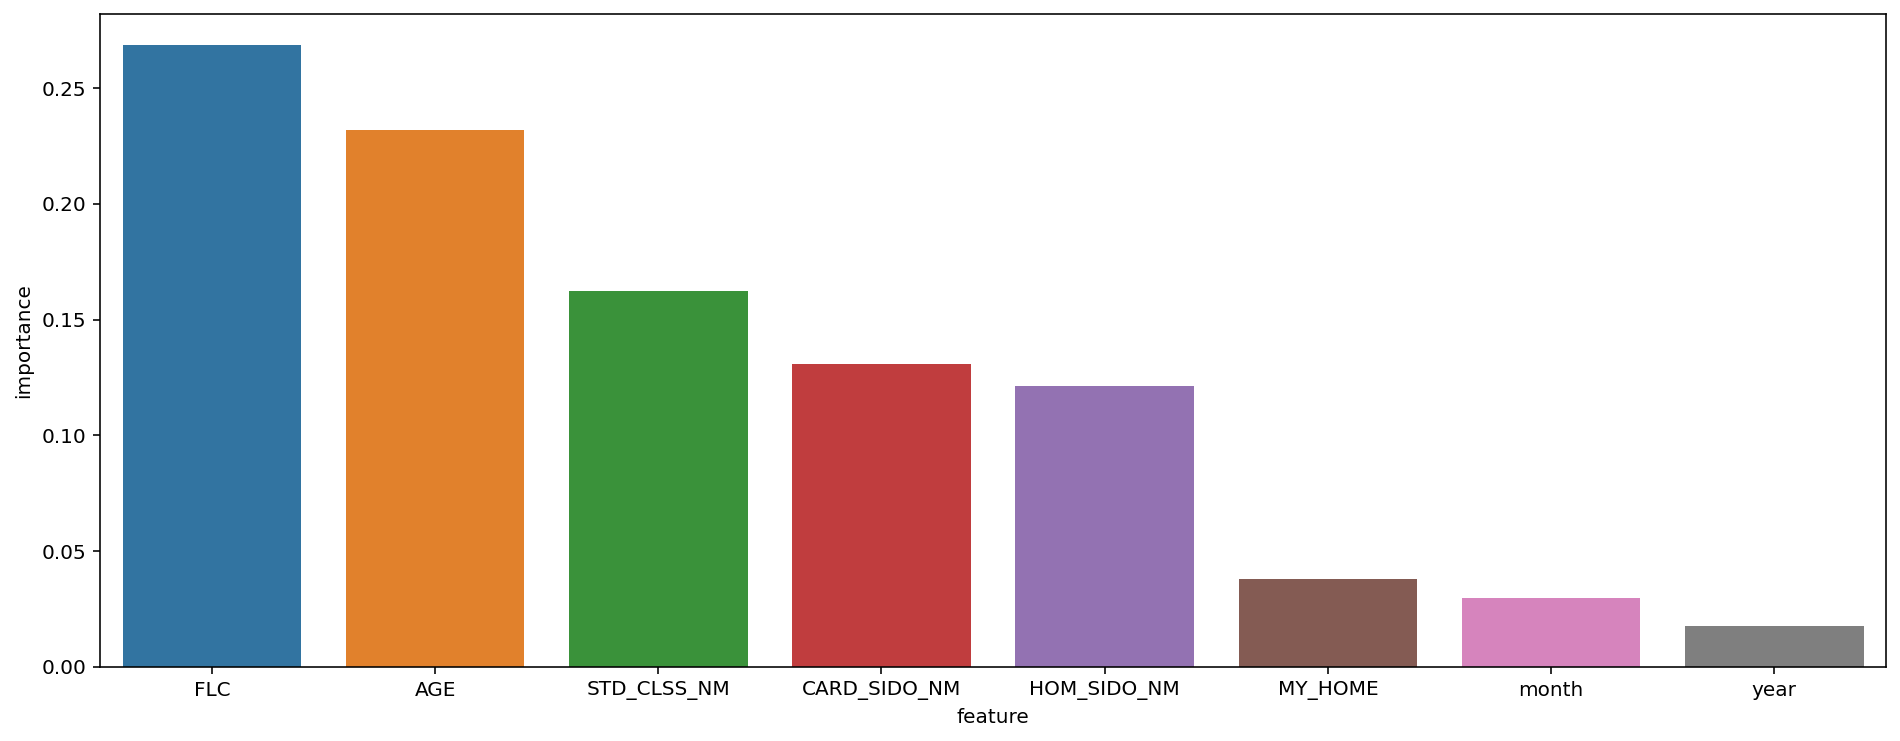

In [ ]:
importances = (pd.DataFrame(model.feature_importances_, index=X_train.columns).
               sort_values(by = 0, ascending = False).
               reset_index().
               rename(columns = {'index' : 'feature', 0 : 'importance'})
              )

plt.figure(figsize=(16,6))
sns.barplot(data = importances, x = 'feature', y = 'importance')

In [29]:
model2 = ExtraTreesRegressor(n_jobs = -1, random_state = 4)
model2.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=4, verbose=0, warm_start=False)

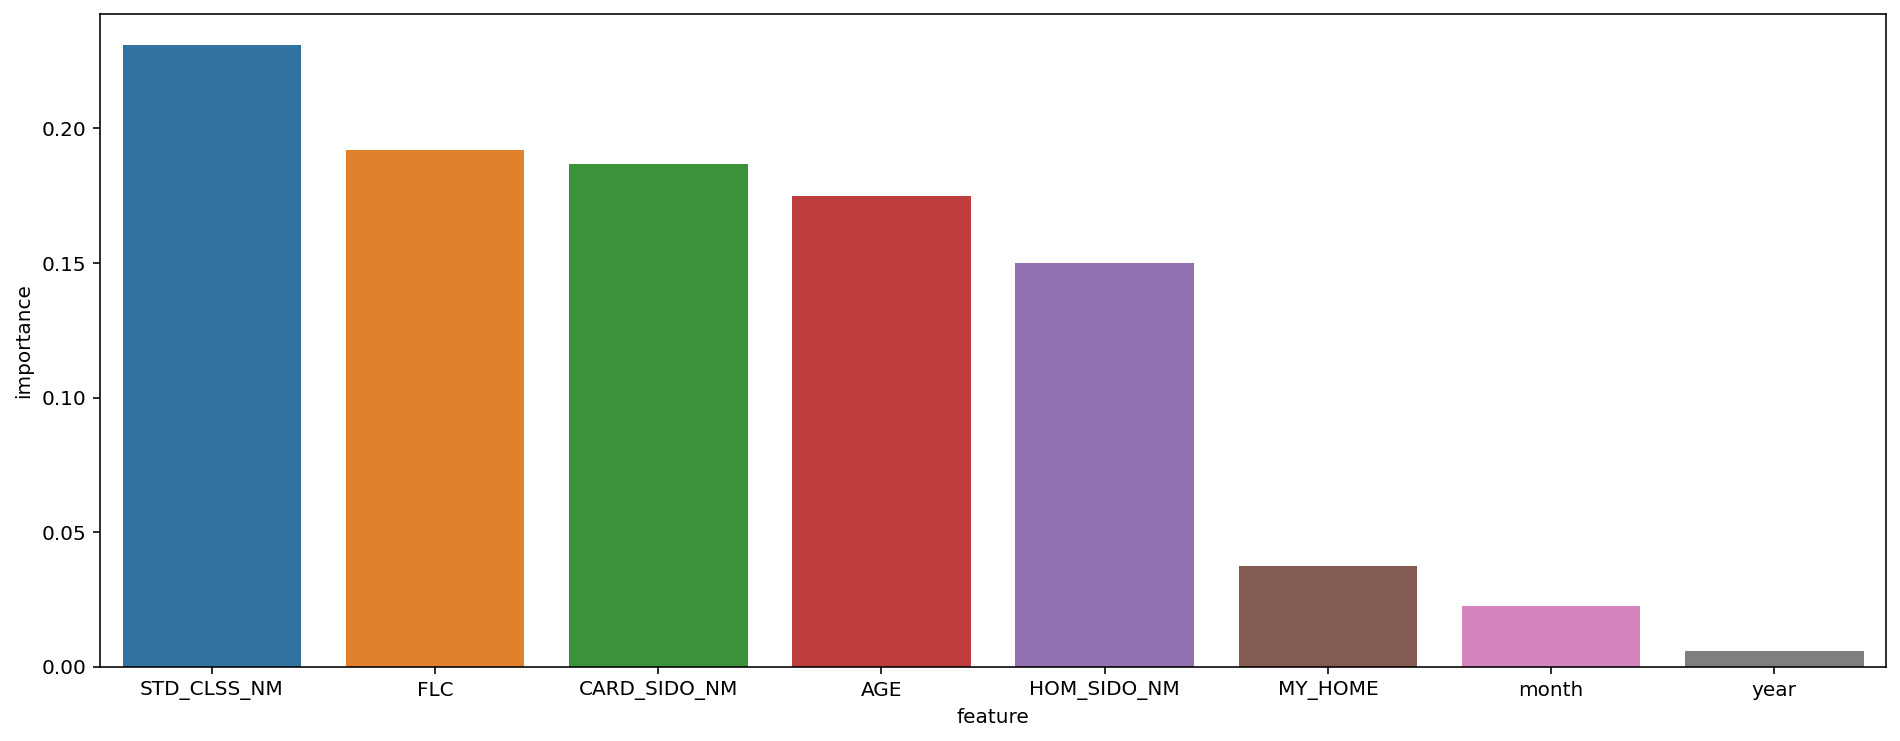

In [ ]:
importances = (pd.DataFrame(model2.feature_importances_, index=X_train.columns).
               sort_values(by = 0, ascending = False).
               reset_index().
               rename(columns = {'index' : 'feature', 0 : 'importance'})
              )

plt.figure(figsize=(16,6))
sns.barplot(data = importances, x = 'feature', y = 'importance')

In [ ]:
predict = cross_val_predict(model, train_features, train_target, cv = 10)
y_predict = np.expm1(predict)

score = mean_squared_log_error(train_num['AMT'], y_predict)
score = np.sqrt(score)

score

1.8774310136671049

### Conclusion & Discussion

In [30]:
# 예측 템플릿 만들기
CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = df_num['HOM_SIDO_NM'].unique()
AGEs          = df_num['AGE'].unique()
SEX_CTGO_CDs  = df_num['SEX_CTGO_CD'].unique()
FLCs          = df_num['FLC'].unique()
years         = [2020]
months        = [4,7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for HOM_SIDO_NM in HOM_SIDO_NMs:
            for AGE in AGEs:
                for SEX_CTGO_CD in SEX_CTGO_CDs:
                    for FLC in FLCs:
                        for year in years:
                            for month in months:
                              temp.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=X_train.columns[:8])
temp.loc[temp['CARD_SIDO_NM'] == temp['HOM_SIDO_NM'], 'MY_HOME'] = 1
temp.loc[temp['CARD_SIDO_NM'] != temp['HOM_SIDO_NM'], 'MY_HOME'] = 0
temp['MY_HOME'] = temp['MY_HOME'].astype(int)

print(temp.shape)
temp.head()

(1658860, 9)


,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,MY_HOME
0,0,0,0,1,1,1,2020,4,1
1,0,0,0,1,1,1,2020,7,1
2,0,0,0,1,1,2,2020,4,1
3,0,0,0,1,1,2,2020,7,1
4,0,0,0,1,1,3,2020,4,1


In [ ]:
# sub과 동일한 템플릿 만들기
CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
years         = [2020]
months        = [4,7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for year in years:
          for month in months:
            temp.append([CARD_SIDO_NM, STD_CLSS_NM, year, month])

temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=['CARD_SIDO_NM', 'STD_CLSS_NM', 'year', 'month'])
print(temp.shape)
temp.head()

# 예측
predict = model2.predict(temp)
predict = np.expm1(predict)
temp['AMT'] = np.round(predict, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)
pred_AMT = list(temp[temp['REG_YYMM'] == 202004]['AMT'])
temp

In [31]:
# 예측
predict = model2.predict(temp)
predict = np.expm1(predict)
temp['AMT'] = np.round(predict, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)
pred_AMT = list(temp[temp['REG_YYMM'] == 202004]['AMT'])
temp

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202004,0,0,9.077225e+07
1,202004,0,1,3.109791e+09
2,202004,0,2,9.643027e+08
3,202004,0,3,1.299536e+07
4,202004,0,4,0.000000e+00
...,...,...,...,...
1389,202007,16,36,1.305600e+09
1390,202007,16,37,1.615760e+10
1391,202007,16,38,1.559996e+07
1392,202007,16,39,4.370870e+08


### Hyperparamter Tuning & Cross Validation

In [ ]:
n_estimators = 10 # 트리의 갯수는 나중에 천천히 올려보겠습니다.
num_epoch = 20    # 반복횟수는 일단 20번 
coarse_hyperparameters_list = [] # hyperparameter 탐색 결과를 리스트로 저장

# num_epoch 횟수만큼 랜덤 서치를 반복합니다.
for epoch in range(num_epoch):
    max_depth = np.random.randint(low = 50, high = 100)
    max_features = np.random.uniform(low = 0.5, high = 1.0)
    model = RandomForestRegressor(n_estimators = n_estimators,
                                  max_depth = max_depth,
                                  max_features = max_features,
                                  n_jobs = -1,
                                  random_state = 4)

    predict = cross_val_predict(model, train_features, train_target, cv = 20)
    y_predict = np.expm1(predict)

    score = mean_squared_log_error(train_num['AMT'], y_predict)
    score = np.sqrt(score)
    
    # hyperparameter 탐색 결과
    hyperparameters = {
        'epoch': epoch,
        'score': score,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'max_features': max_features,
    }
    coarse_hyperparameters_list.append(hyperparameters)
    print(f"{epoch:2} n_estimators = {n_estimators}, max_depth = {max_depth:2}, max_features = {max_features:.6f}, Score = {score:.5f}")

# coarse_hyperparameters_list를 Pandas의 DataFrame으로 변환합니다.
coarse_hyperparameters_list = pd.DataFrame.from_dict(coarse_hyperparameters_list)
coarse_hyperparameters_list = coarse_hyperparameters_list.sort_values(by="score")

print(coarse_hyperparameters_list.shape)
coarse_hyperparameters_list.head(10)

In [32]:
# RMSLE 계산함수
def rmsle(y, y_,convertExp=False):
    if convertExp:
        y = np.exp(y), 
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

# 2020년 3월과 2020년4월의 AMT값이 거의 같다는 가정으로 2020년3월의 AMT 과 비교하여 단순 모델의 성능향상을 확인해 볼수 있음
data202003 = row_data.copy()
data202003 = data202003[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
data202003 = data202003.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)
data202003 = data202003.loc[data202003['REG_YYMM']==202003]
data202003 = data202003[['CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]


submission_temp = pd.read_csv('/gdrive/My Drive/data_analysis/jeju/submission.csv', index_col=0)
submission_temp = submission_temp.loc[submission_temp['REG_YYMM']==202004]
submission_temp = submission_temp[['CARD_SIDO_NM', 'STD_CLSS_NM']]
submission_temp = submission_temp.merge(data202003, left_on=['CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission_temp = submission_temp.fillna(1)
AMT = list(submission_temp['AMT'])

print(rmsle(AMT, pred_AMT))

0.7881687154734192


In [33]:
# 디코딩
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [34]:
# 제출 파일 만들기
submission = pd.read_csv('/gdrive/My Drive/data_analysis/jeju/submission.csv', index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission.index.name = 'id'
submission.fillna(1)
submission.to_csv('/gdrive/My Drive/data_analysis/jeju/submission_16.csv', encoding='utf-8-sig')
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,9.077225e+07
1,202004,강원,골프장 운영업,3.109791e+09
2,202004,강원,과실 및 채소 소매업,9.643027e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,1.299536e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00


- 1차 (2020.07.08) : 7.0952616618 기본베이스라인
- 2차 (2020.07.10) : 7.0397573431 기본베이스라인 코드 하이퍼파라미트 튜닝
- 3차 (2020.07.13) : 7.0640860184 outlier 제거후 
- 4차 (2020.07.14) : 6.98248 생활권 비생활권의 피쳐를 생성하여 학습진행
- 5차 (2020.07.14) : 8.2871435947 소비자동향지수데이터 이용 2020년3월까지의 데이터를 이용하여 2020년4월/7월의 소비자동향지수를 예측하여 예측한 동향지수를 가지고 학습을 진행
- 6차 (2020.07.15) : 7.659012519 결제고객수와 결제건수의 차이를 이용하여 새로운 피쳐를 생성
- 7차 (2020.07.16) : 7.291081002 4월,7월의 결제고객수와 결제건수를 각각 예측한뒤 학습데이터에 넣어서 예측
- 8차 (2020.07.17) : 5.5699394201 2019년 2월/3월/4월 , 2020년 2월/3월 데이터만을 모델에 학습
- 12차 (2020.07.24) : 2.6587105699 모델 학습에 사용된 피쳐(연/월 데이터 2019.02/03/04 ~ 2020.02.03 + 카드사용지역 + 업종 + 사용자거주지역 + 연령 + 생애주기 + 생활권) // 기본 전체 데이터에서 연/월 데이터를 필요한것만 추리고 성별 데이터는 뺐음 데이터에서 모든 조합의 경우를 만들고 빈값은 1로 채워 모델 학습(자체스코어 2.32029)
- 13차 (2020.07.24) : 1.9489019929 빈값을 0으로 채우고 모델 학습(자체스코어 1.5192364)
- 14차 (2020.07.24) : 1.51132 / 1등(현시점): 13차 제출과 모든것이 동일 ExtraTreesRegressor모델로 변경(자체 스코어 0.66970846388974)
- 15차 (2020.07.25) : 1.5775297675 14차와 동일한 상태에서 성별 피쳐 추가 자체스코어(0.7881687154734192)